# A/B testing using Python

We’ll use a [dataset from Kaggle](https://www.kaggle.com/datasets/zhangluyuan/ab-testing?select=ab_data.csv) which contains the results of an A/B test on what seems to be 2 different designs of a website page (old_page vs. new_page)

There are few steps we will do:
1. Design our experiment
2. Collecting and preparing the data
3. Visualizing the results
4. Testing the hypothesis
5. Drawing conclusions

Why do we do A/B testing:
Let’s imagine you work on the product team at a medium-sized online e-commerce business. The UX designer worked really hard on a new version of the product page, with the hope that it will lead to a higher conversion rate. The product manager (PM) told you that the current conversion rate is about 13% on average throughout the year, and that the team would be happy with an increase of 2%, meaning that the new design will be considered a success if it raises the conversion rate to 15%.

Before rolling out the change, the team would be more comfortable testing it on a small number of users to see how it performs, so you suggest running an A/B test on a subset of your user base users.

This notebook is learned from [here](https://towardsdatascience.com/ab-testing-with-python-e5964dd66143).

## 1. Designing our experiment


Given we don’t know if the new design will perform better or worse (or the same?) as our current design, we’ll choose a two-tailed test:

$H_0$: p = $p_0$  
$H_a$: p $\neq$ $p_0$  

where p and pₒ stand for the conversion rate of the new and old design, respectively. We’ll also set a confidence level of 95%:

$\alpha$ = 0.05

**Choosing the variables**  
For our test we’ll need two groups:

- A `control` group - They'll be shown the old design
- A `treatment` (or experimental) group - They'll be shown the new design  

This will be our Independent Variable. The reason we have two groups even though we know the baseline conversion rate is that we want to control for other variables that could have an effect on our results, such as seasonality: by having a control group we can directly compare their results to the treatment group, because the only systematic difference between the groups is the design of the product page, and we can therefore attribute any differences in results to the designs.

For our Dependent Variable (i.e. what we are trying to measure), we are interested in capturing the conversion rate. A way we can code this is by each user session with a binary variable:

- 0 - The user did not buy the product during this user session
- 1 - The user bought the product during this user session  

This way, we can easily calculate the mean for each group to get the conversion rate of each design.

**Choosing a sample size**  
The number of people (or user sessions) we decide to capture in each group will have an effect on the precision of our estimated conversion rates: the larger the sample size, the more precise our estimates (i.e. the smaller our confidence intervals), the higher the chance to detect a difference in the two groups, if present.

On the other hand, the larger our sample gets, the more expensive (and impractical) our study becomes.

_so how many people should we have in each group?_  

The sample size can be estimated through something called power analysis, and it depends on a few factors

- Power of the test (1 — β) — This represents the probability of finding a statistical difference between the groups in our test when a difference is actually present. This is usually set at 0.8 by convention (here’s more info on statistical power, if you are curious)
- Alpha value (α) — The critical value we set earlier to 0.05
- Effect size — How big of a difference we expect there to be between the conversion rates

Since our team would be happy with a difference of 2%, we can use 13% and 15% to calculate the effect size we expect.

In [1]:
#required package
import numpy as np
import pandas as pd
import scipy.stats as stats
import statsmodels.stats.api as sms
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from math import ceil

%matplotlib inline

# Some plot styling preferences
plt.style.use('seaborn-whitegrid')
font = {'family' : 'Helvetica',
        'weight' : 'bold',
        'size'   : 14}

mpl.rc('font', **font)

In [3]:
# Calculating effect size based on our expected rates
effect_size = sms.proportion_effectsize(0.13, 0.15)
# Calculating same size needed
required_n = sms.NormalIndPower().solve_power(effect_size, power=0.8, alpha=0.05, ratio=1)
# rounding up
required_n = ceil(required_n)
required_n

4720

We’d need **at least 4720 observations for each group**.

Having set the power parameter to 0.8 in practice means that if there exists an actual difference in conversion rate between our designs, assuming the difference is the one we estimated (13% vs. 15%), we have about 80% chance to detect it as statistically significant in our test with the sample size we calculated.

## 2: collecting and preparing the data

1. Download the dataset from Kaggle
2. Read the data into a pandas DataFrame
3. Check and clean the data as needed
4. Randomly sample n=4720 rows from the DataFrame for each group *

In [20]:
df = pd.read_csv("ab_data.csv")
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


In [22]:
# To make sure all the control group are seeing the old page and viceversa
pd.crosstab(df['group'], df['landing_page'])

landing_page,new_page,old_page
group,,
control,1928,145274
treatment,145311,1965


There are 294478 rows in the DataFrame, each representing a user session, as well as 5 columns :

- `user_id` - The user ID of each session
- `timestamp` - Timestamp for the session
- `group` - Which group the user was assigned to for that session {control, treatment}
- `landing_page` - Which design each user saw on that session {old_page, new_page}
- `converted` - Whether the session ended in a conversion or not (binary, 0=not converted, 1=converted)

In [23]:
'''
Before we go ahead and sample the data to get our subset, 
let’s make sure there are no users that have been sampled multiple times.
'''
session_counts = df['user_id'].value_counts(ascending=False)
multi_users = session_counts[session_counts > 1].count()

print(f'There are {multi_users} users that appear multiple times in the dataset')
df.drop_duplicates(subset=['user_id'], inplace=True)
df.shape[0]

There are 3894 users that appear multiple times in the dataset


290584

**Sampling**  
Now that our DataFrame is nice and clean, we can proceed and sample n=4720 entries for each of the groups. We can use pandas' DataFrame.sample() method to do this, which will perform Simple Random Sampling for us.

In [27]:
control_sample = df.query("group == 'control'").sample(n= required_n)
treatment_sample = df.query("group == 'treatment'").sample(n= required_n)
ab_test = pd.concat([control_sample, treatment_sample], axis = 0).reset_index(drop = True)
ab_test.head(5)


,user_id,timestamp,group,landing_page,converted
0,814876,2017-01-23 01:49:05.925807,control,old_page,0
1,714190,2017-01-03 08:04:15.815538,control,old_page,0
2,887970,2017-01-06 10:45:32.514244,control,old_page,0
3,892133,2017-01-18 10:40:09.665205,control,old_page,0
4,809416,2017-01-12 08:53:53.090321,control,old_page,1


In [28]:
pd.crosstab(ab_test['group'], ab_test['landing_page'])

landing_page,new_page,old_page
group,,
control,34,4686
treatment,4682,38


In [29]:
ab_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9440 entries, 0 to 9439
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   user_id       9440 non-null   int64 
 1   timestamp     9440 non-null   object
 2   group         9440 non-null   object
 3   landing_page  9440 non-null   object
 4   converted     9440 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 368.9+ KB


In [30]:
ab_test['group'].value_counts()

control      4720
treatment    4720
Name: group, dtype: int64

## 3: Visualizing the results


In [32]:
#some basic statistics
conversion_rates = ab_test.groupby('group')['converted']
# std deviation of the proportion
std_p = lambda x:np.std(x)
# std error of the proporation
se_p = lambda x: stats.sem(x)

conversion_rates = conversion_rates.agg([np.mean, std_p, se_p])
conversion_rates.columns = ['conversion_rate', 'std_deviation', 'std_error']

conversion_rates.style.format('{:.3f}')

,conversion_rate,std_deviation,std_error
group,,,
control,0.121,0.326,0.005
treatment,0.119,0.324,0.005


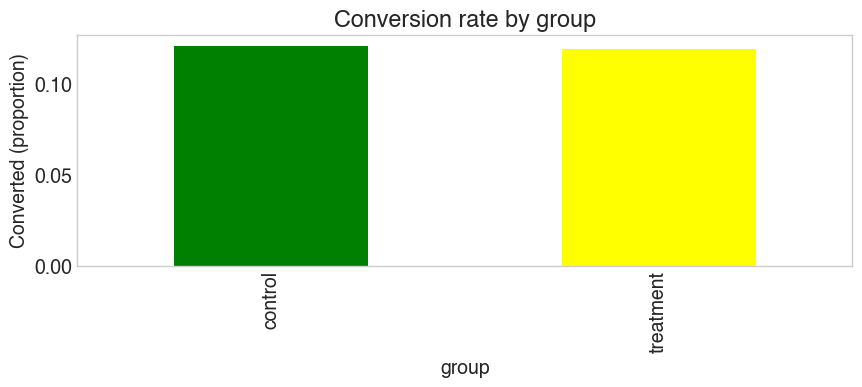

In [47]:
conversion_rates['conversion_rate'].plot\
    .bar(title = "Conversion rate by group", color = ['green','yellow'],
         figsize = (10, 3), grid = False,
        ylabel = "Converted (proportion)");


## 4: Testing Hypothesis
Since we have a very large sample, we can use the normal approximation for calculating our p-value (i.e. z-test).

In [50]:
# this is a 2 sample proportion ztest

from statsmodels.stats.proportion import proportions_ztest, proportion_confint

control_results = ab_test[ab_test['group'] == 'control']['converted']
treatment_results = ab_test[ab_test['group'] == 'treatment']['converted']

n_con = control_results.count()
n_treat = treatment_results.count()
successes = [control_results.sum(), treatment_results.sum()]
nobs = [n_con, n_treat]

z_stat, pval = proportions_ztest(successes, nobs = nobs)
(lower_con, lower_treat), (upper_con, upper_treat) = proportion_confint(successes, nobs, alpha = 0.05)

print(f'z statistic: {z_stat:.2f}')
print(f'p-value: {pval:.3f}')
print(f'ci 95% for control group: [{lower_con:.3f}, {upper_con:.3f}]')
print(f'ci 95% for treatment group: [{lower_treat:.3f}, {upper_treat:.3f}]')


z statistic: 0.32
p-value: 0.751
ci 95% for control group: [0.112, 0.130]
ci 95% for treatment group: [0.110, 0.128]


Since our p-value=0.732 is way above our α=0.05 threshold, we cannot reject the Null hypothesis Hₒ, which means that our new design did not perform significantly different (let alone better) than our old one :(

Additionally, if we look at the confidence interval for the treatment group ([0.116, 0.135], or 11.6-13.5%) we notice that:

- It includes our baseline value of 13% conversion rate
- It does not include our target value of 15% (the 2% uplift we were aiming for)

What this means is that it is more likely that the true conversion rate of the new design is similar to our baseline, rather than the 15% target we had hoped for. This is further proof that our new design is not likely to be an improvement on our old design, and that unfortunately we are back to the drawing board!